# Pathfinder tests

The goal of this module is to test the functionality of the pathfinder modules using the pre-saved data from the fullscan pathfinder.

In [73]:
from mpl_toolkits import mplot3d
import sys
sys.path.append('..\\')
# print(sys.path)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator

%load_ext autoreload
%autoreload 2

from Pathfinders import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Unload the data from a particular scan
This should only include data from a Fullscan module

In [74]:
a = [[a, a+1, a+2] for a in range(4)]

points = np.array(a)
print(points)

[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]]


In [81]:
path = os.path.abspath('..\\')
test_no = 0
# current_file = r"\Debugging Scripts\test_%s.json" % test_no
current_file = r"\test_%s.json" % test_no

# print(path)

with open(path + current_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
scan_max = json_data["max_point"]

r = dict()
active_rom = []
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2
    if r[DoF] != 0.0:
        active_rom.append(DoF)
print(active_rom)

indeces = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}

print(point_mags[0])
print(type(point_mags))
print(r_o_m)

# points = np.array([[p[0][int(i/3)][i%3] for i in range(6)] for p in point_mags])
points = np.array([[p[0][indeces[a][0]][indeces[a][1]] for a in active_rom] for p in point_mags])
mags = np.array([p[1] for p in point_mags])

print(np.shape(points))

linInter = LinearNDInterpolator(points, mags)


['Z', 'Rx', 'Ry']
[[[0.0, 0.0, -12.5], [-40.0, -40.0, 0.0]], 6.44577521897922]
<class 'list'>
{'X': [0, 0], 'Y': [0, 0], 'Z': [-12.5, 7.5], 'Rx': [-40, 40], 'Ry': [-40, 40], 'Rz': [0, 0]}
(68921, 3)


In [82]:
r = dict()
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2
print(r)

p_dict = dict()
for p in point_mags:
    p_dict[(tuple(p[0][0]),tuple(p[0][1]))] = p[1]


# scanner = DivisionSearch(4, r['Z'], r['Rx'], r['Ry'])
scanner = Discrete_degree(r['Z'], r['Rx'], r['Ry'])

p = scanner.next()

i = 0
 
while p != 1 and i < 10000:
    i += 1
    if i == 64:
        print('here goes trouble')

    request = np.array([p[indeces[a][0]][indeces[a][1]] for a in active_rom])

    mag = linInter(request)
    # print(mag[0])

    scanner.newMag((p, mag[0]), True)
    # print(p)
    p = scanner.next()

print(i)

file_itr = 0
while os.path.exists(path + "\\Debugging Scripts\\test_%s_%s.json" % (test_no, file_itr)):
    file_itr += 1

output_file = "\\Debugging Scripts\\test_%s_%s.json" % (test_no, file_itr)
print(path + output_file)

scanner.save_points(path + output_file)

{'X': 0.0, 'Y': 0.0, 'Z': 10.0, 'Rx': 40.0, 'Ry': 40.0, 'Rz': 0.0}
['Z', 'Rx', 'Ry']
here goes trouble
1092
c:\Users\ander\Documents\COBOT-Transducer-Control-Code\Rebuilding_Everything\Debugging Scripts\test_10_1.json


In [83]:
with open(path + output_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
# divisions = json_data["divisions"]
point_mags_2 = json_data["points"]
search_max = json_data["max_point"]

print(len(point_mags_2))

1092


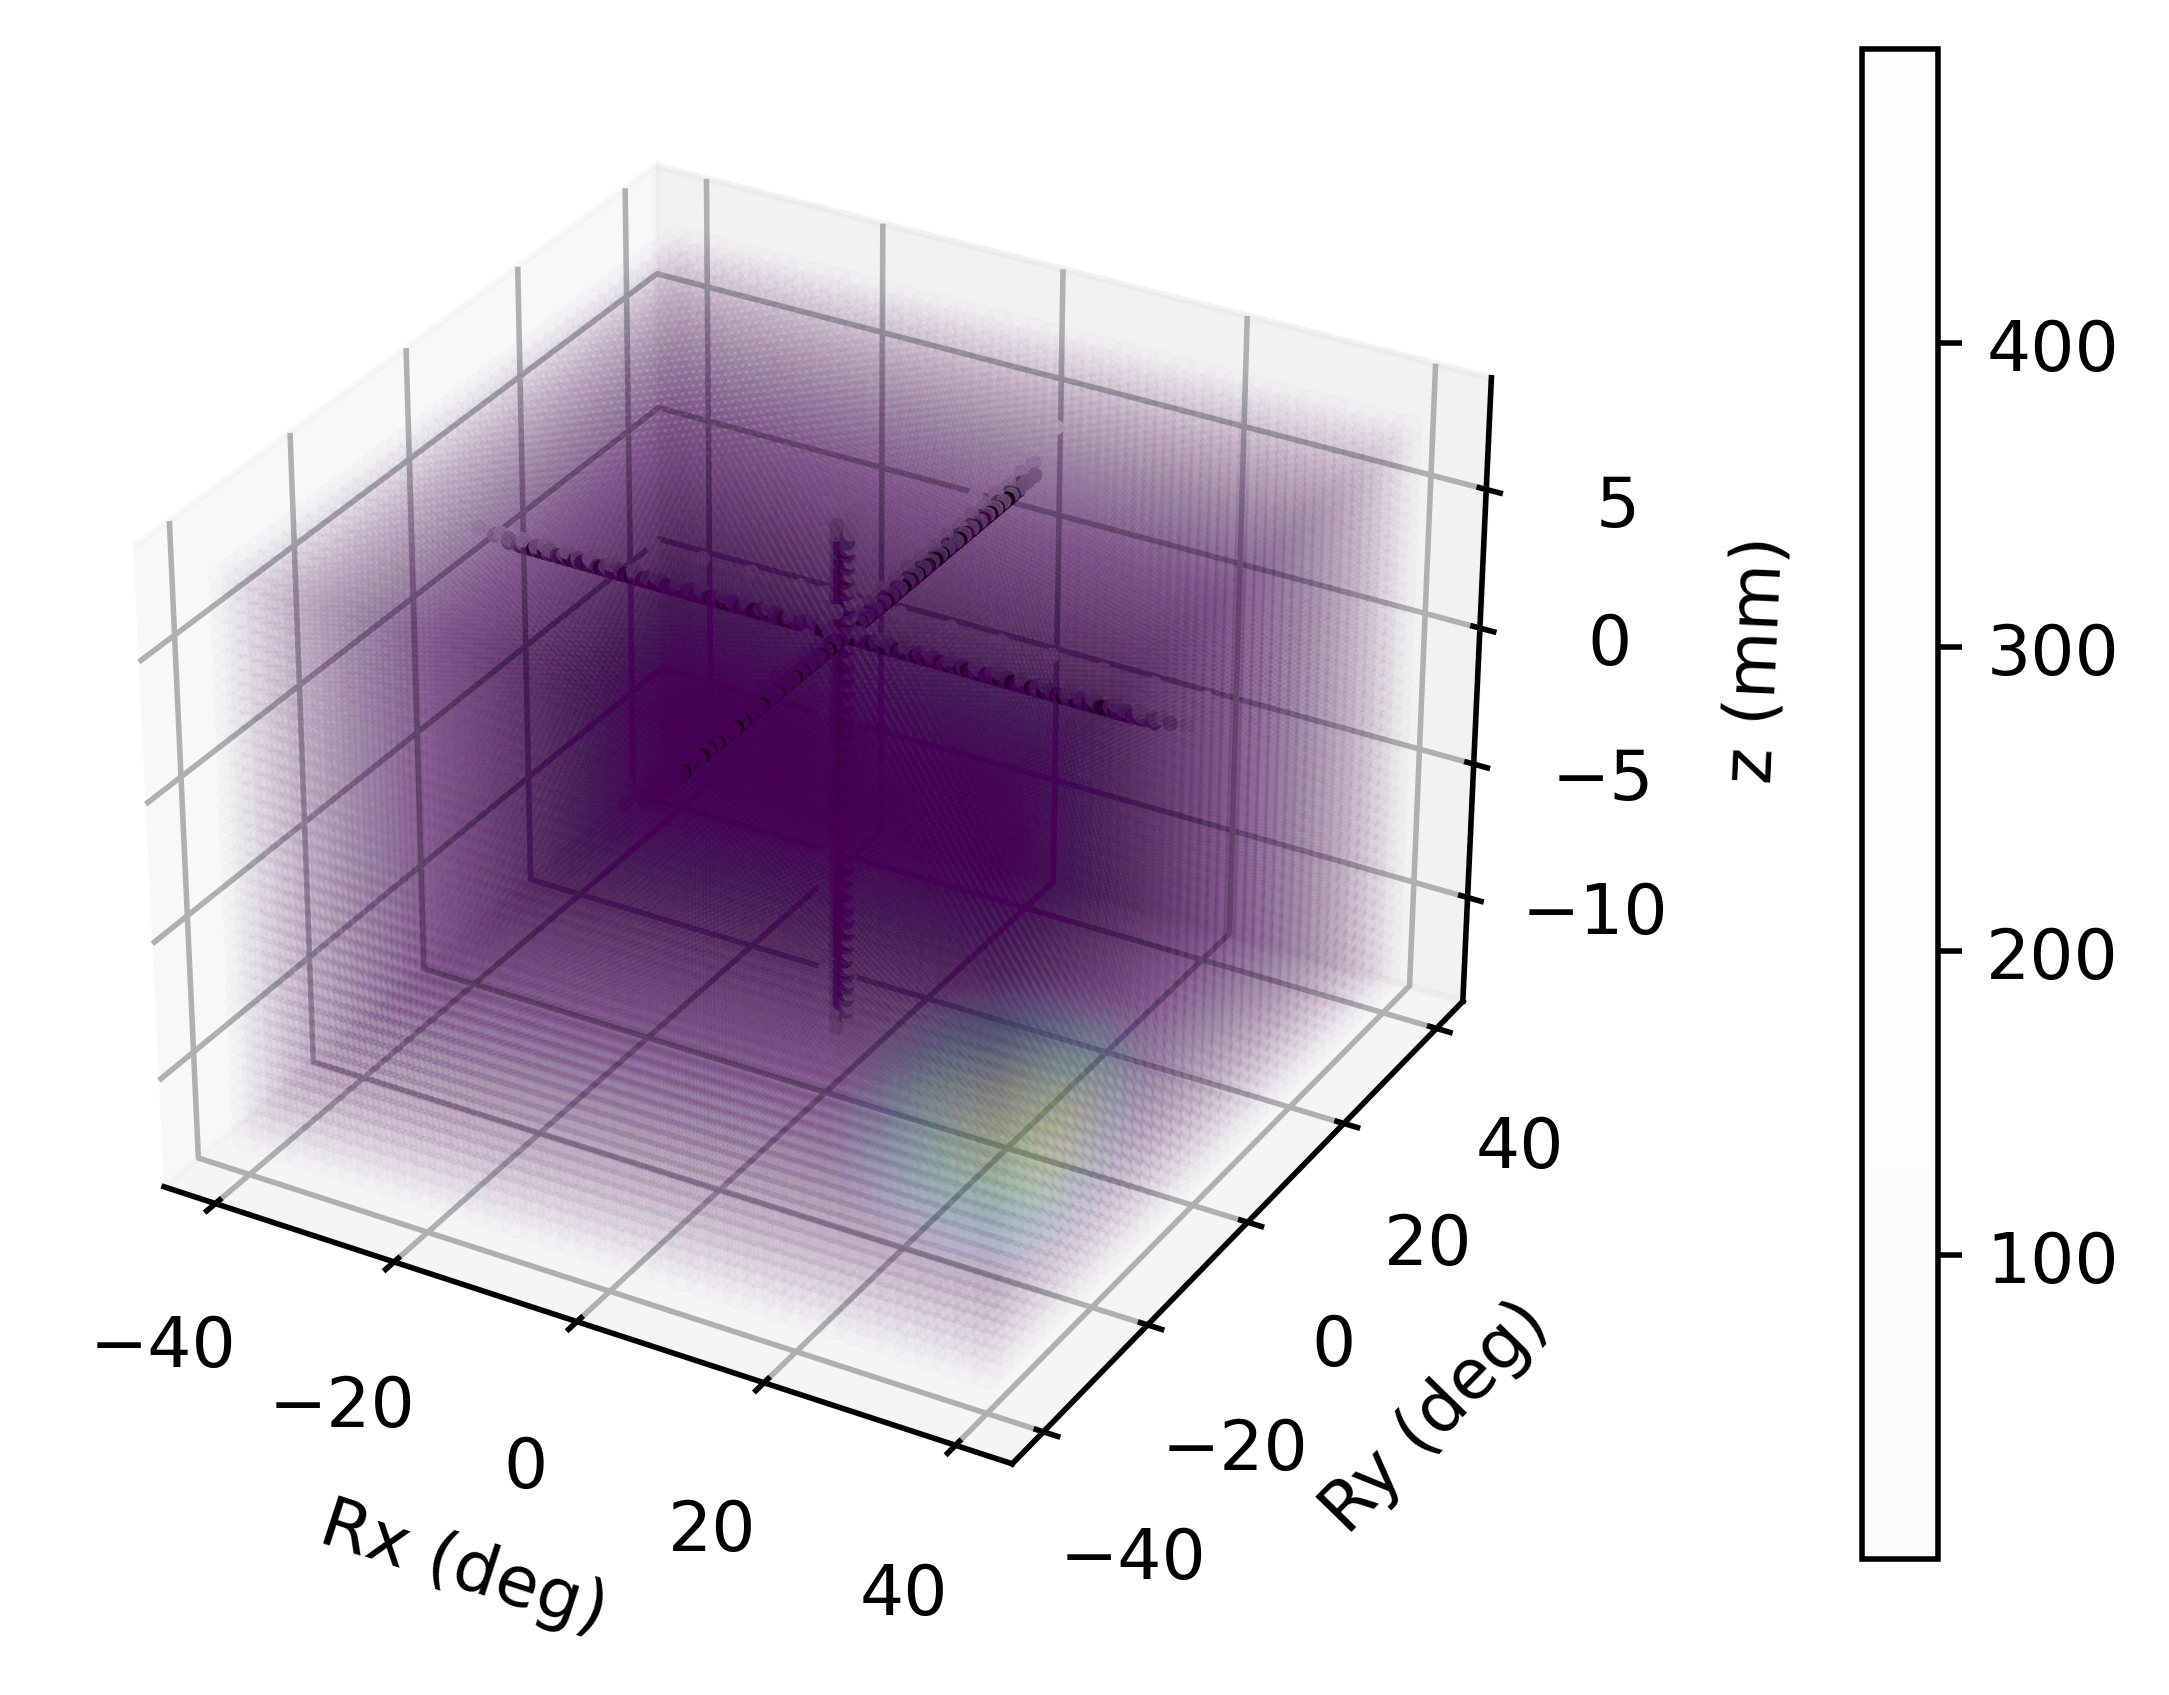

Scan max value: [[[0.0, 0.0, -7.0], [34.0, -26.0, 0.0]], 496.875]
Search max value: [[[0, 0, 2.9994496422674732], [2.1097046413502127, 0, 0]], 14.630435225027075]


In [84]:
Zs = []
Rxs = []
Rys = []
mags = []

for p in point_mags:
    Zs.append(p[0][0][2])
    Rxs.append(p[0][1][0])
    Rys.append(p[0][1][1])
    mags.append(p[1])

ax = plt.axes(projection='3d')

# print(max(mags))
# print(min(mags))

floor = min(mags)
span = max(mags) - floor
als = [round((i - floor) / (span * 2) * 256) for i in mags]
als = [i / 256 for i in als]
# print(len(Rys))
# print(len(Rxs))

fig = ax.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.01, linewidth=0.25)

plt.colorbar(fig, pad=0.13)

Zs = []
Rxs = []
Rys = []

for p in point_mags_2:
    Zs.append(p[0][0][2])
    Rxs.append(p[0][1][0])
    Rys.append(p[0][1][1])

fig = ax.scatter(Rxs, Rys, Zs, c=range(len(Zs)), cmap='binary', alpha=0.9, linewidth=0.25, s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")

plt.rcParams['figure.dpi'] = 500

# plt.savefig("fullscan_render.jpg", dpi=400)
plt.show()
# plt.axes(projection = "3d")
# plt.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.8, linewidth=0.5)


print(f"Scan max value: {scan_max}")
print(f"Search max value: {search_max}")

In [79]:
current_best = [[0,0,0],[0,0,0]]

# current_best[0][1] = 1

print((tuple(current_best[0]),tuple(current_best[1])))

((0, 0, 0), (0, 0, 0))
